In [43]:
from qiskit import *
import numpy as np
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.primitives import StatevectorSampler
from qiskit.transpiler import generate_preset_pass_manager


def oracle_operator(s): 
    
    n = len(s)
    
    qc = QuantumCircuit(n+1)
    
    for i, bit in enumerate(s):
        if bit == '0':
            qc.x(i)
            
    qc.mcx(list(range(n)), n)
    
    for i, bit in enumerate(s):
        if bit == '0':
            qc.x(i)

    return qc
    

def diffusion_operator(n):
    
    qc = QuantumCircuit(n)
    
    qc.h(list(range(n)))
    qc.x(list(range(n)))
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)
    qc.h(n-1)
    qc.x(list(range(n)))
    qc.h(list(range(n)))

    return qc
    
    
def grovers_algorithm(oracle, n):
    
    #Step 1
    qc = QuantumCircuit(n+1, n)
    
    #Step 2
    qc.x(n)
    qc.h(n)
    
    
    #Step 3
    qc.h(list(range(n)))
    
    #Step 4
    N = int(np.ceil(np.pi / 4 * np.sqrt(2**n))) -1 
    
    #Step 5
    for _ in range(N):
        qc.barrier()
        qc.compose(oracle, range(n+1), inplace=True)
        qc.barrier()
        qc.compose(diffusion_operator(n), range(n), inplace=True)
        
    #Step 6
    qc.measure(list(range(n)) , reversed(list(range(n))))
    
    return qc

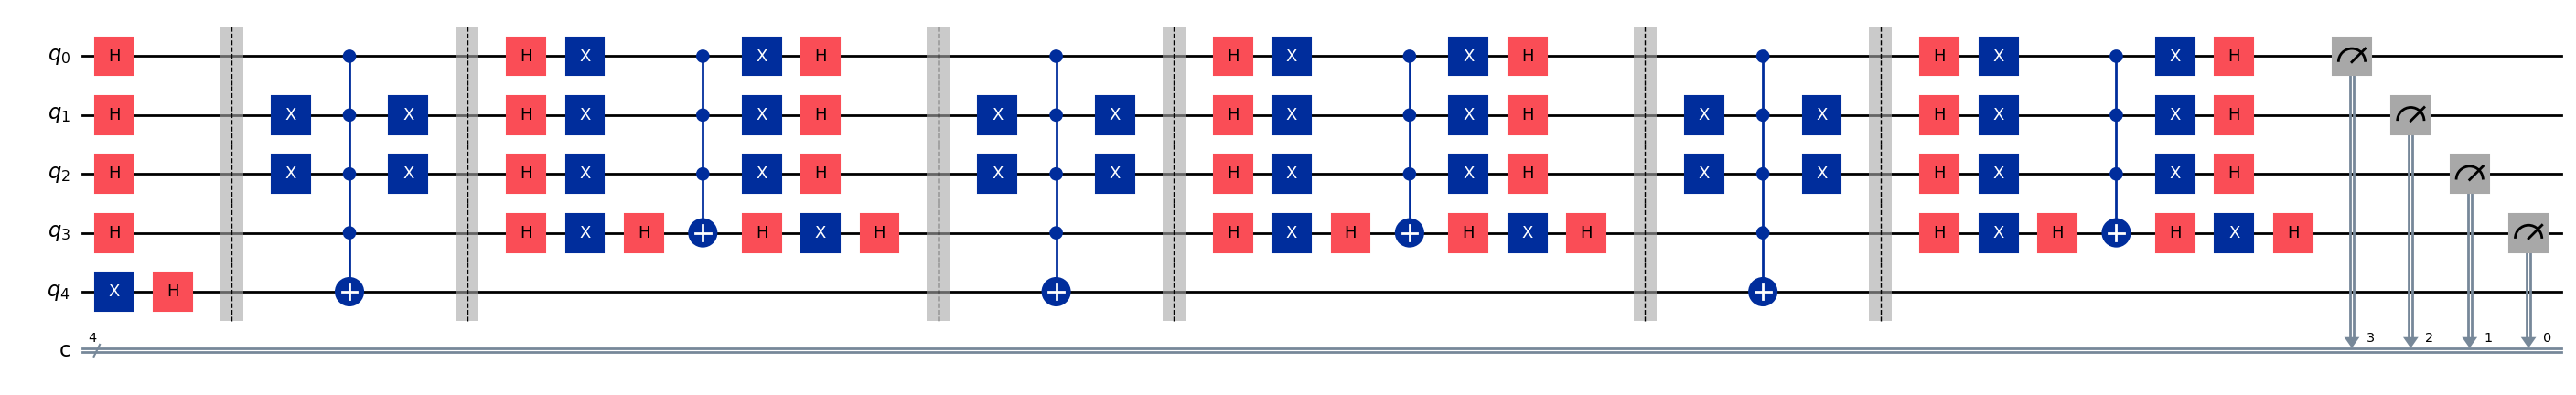

In [44]:
#Example required by the assignment   
oracle = oracle_operator("1001")
qc = grovers_algorithm(oracle, 4)
qc.draw('mpl', fold=False)

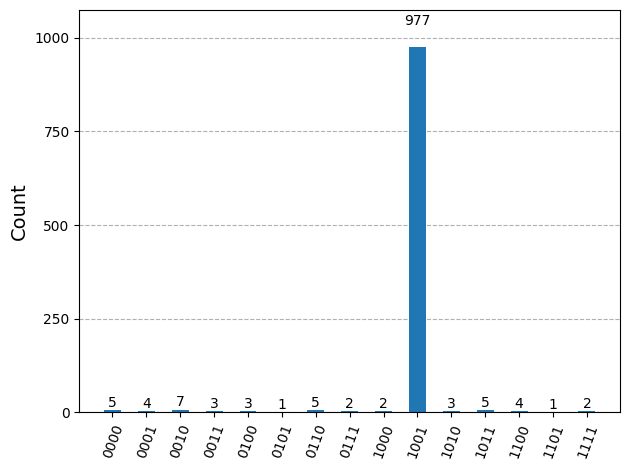

In [45]:
#Simulation using StatevectorSampler
pm = generate_preset_pass_manager(optimization_level=3)
transpiled_qc = pm.run(qc)
statevectorSampler = StatevectorSampler()
job = statevectorSampler.run([transpiled_qc])
pub_result = job.result()[0]
counts = pub_result.data.c.get_counts()
plot_histogram(counts)

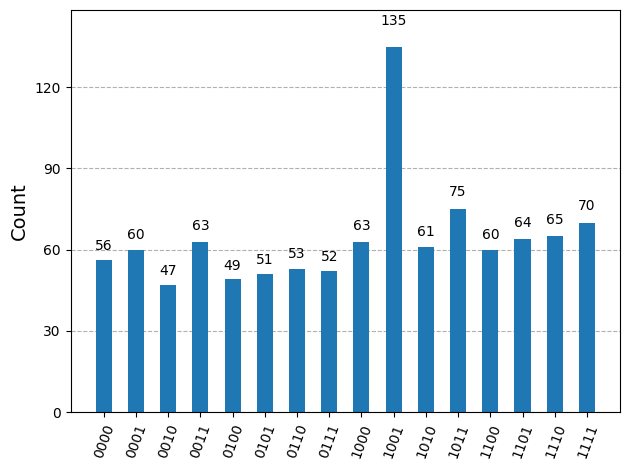

In [46]:
#Simulation using SamplerV2
backend = FakeSherbrooke()
shots=1024
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
transpiled_qc = pm.run(qc)
sampler = SamplerV2(mode=backend)
job = sampler.run([transpiled_qc],shots=shots)
pub_result = job.result()[0]
counts = pub_result.data.c.get_counts()
plot_histogram(counts)

/tmp/ipykernel_33587/3001265627.py:2: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


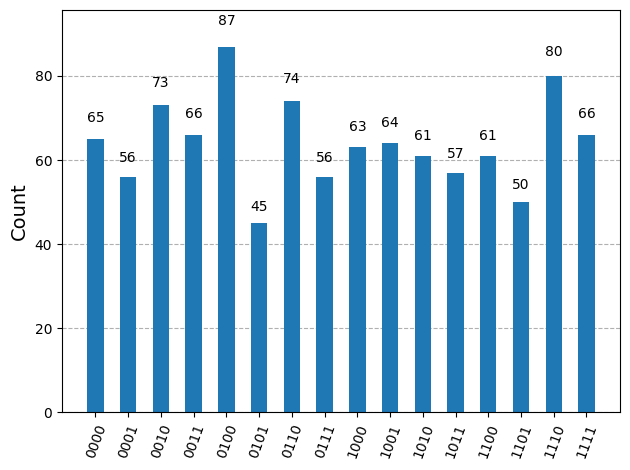

In [49]:
#Execution on a real quantum computer
service = QiskitRuntimeService(
    channel='ibm_quantum',
    token='QISKIT_TOKEN>'
)

shots=1024

backend = service.least_busy(operational=True, simulator=False)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
transpiled_qc = pm.run(qc) 
sampler = SamplerV2(backend)
job = sampler.run([transpiled_qc], shots=shots)
pub_result = job.result()[0]
counts = pub_result.data.c.get_counts()
plot_histogram(counts)